<Font Color ="red">**Problem statement:** </Font> <Font Color ="blue"> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. </Font>


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/CNN_Assign_Folder'

##### Extracting Skin Cancer Data - unzipping the data

In [ ]:
!rm -r skin
!unzip //content/gdrive/MyDrive/CNN_Assign_Folder/CNN_assignment.zip

rm: cannot remove 'skin': No such file or directory
Archive:  //content/gdrive/MyDrive/CNN_Assign_Folder/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imag


<Font Color ="green">The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant. </Font >

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from skimage import io
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
num_classes=9

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
 batch_size=batch_size,
 image_size=(img_height,img_width),
 shuffle=True,
 seed=123,
 validation_split=0.2,
 subset='training')



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
 batch_size=batch_size,
 image_size=(img_height,img_width),
 shuffle=True,
 seed=123,
 validation_split=0.2,
 subset='validation')


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Following is the list of all the classes of skin cancer (stored in a list).
# These class names are retrieved from the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

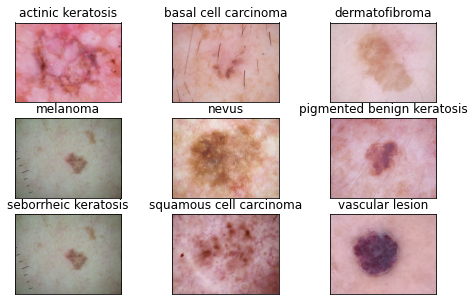

In [ ]:
import matplotlib.pyplot as plt
im_array=[]
for d1 in os.listdir(data_dir_train):
    file1=os.listdir(os.path.join(data_dir_train,d1))[0]
    im_array.append(os.path.join(data_dir_train,d1,file1))
fig=plt.figure(figsize=(8,5))
#To display the first image from all the 9 categories along with the names of the categories
for i in range(len(class_names)):
    ax=fig.add_subplot(3,3,1+i,xticks=[],yticks=[])
    img_path=(img for img in im_array if class_names[i] in img)
    ax.set_title(class_names[i])
    img=io.imread(list(img_path)[0])
    plt.imshow(img)
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Following is a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(16,3,padding="same",
                 activation='relu',
                 input_shape=(img_height,img_width,-1))) 
model.add(MaxPooling2D())
# second conv layer
model.add(Conv2D(32,3,padding="same",
                 activation='relu',
                 input_shape=(img_height,img_width,-1))) 
model.add(MaxPooling2D())
# third conv layer
model.add(Conv2D(64, 3, 
                 activation='relu'))
model.add(MaxPooling2D())

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128,activation='relu')) # fully connected


# softmax layer
model.add(Dense(num_classes))

# model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 64)        1

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Appropriate optimiser and loss function are used
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 64)        1

### Train the model

In [ ]:
epochs=20
history = model.fit(train_ds,
validation_data=val_ds,
batch_size=batch_size,
epochs=epochs)

Epoch 1/20
56/56 [==============================] - 66s 972ms/step - loss: 1.9785 - accuracy: 0.2706 - val_loss: 1.7019 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 50s 896ms/step - loss: 1.6581 - accuracy: 0.4051 - val_loss: 1.5262 - val_accuracy: 0.5168
Epoch 3/20
56/56 [==============================] - 50s 895ms/step - loss: 1.4432 - accuracy: 0.4816 - val_loss: 1.4327 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 51s 920ms/step - loss: 1.2829 - accuracy: 0.5469 - val_loss: 1.3821 - val_accuracy: 0.5526
Epoch 5/20
56/56 [==============================] - 50s 894ms/step - loss: 1.1997 - accuracy: 0.5709 - val_loss: 1.4179 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 52s 929ms/step - loss: 1.1290 - accuracy: 0.5988 - val_loss: 1.3894 - val_accuracy: 0.5660
Epoch 7/20
56/56 [==============================] - 50s 897ms/step - loss: 1.0611 - accuracy: 0.6289 - val_loss: 1.4279 - val_accuracy: 0.5123

### Visualizing training results

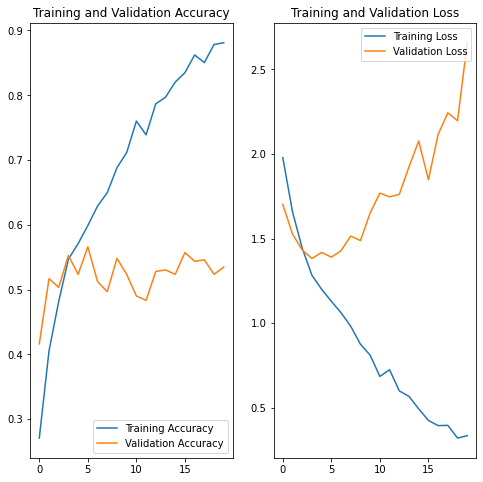

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### <font color ="green">Findings after the model fit: </font>
<font color ="red"> There is an evidence of model overfit.
 The model is performimg well with the training data but not giving appropriate results with the validation data.
 </font>

####  Data Augmentation

In [ ]:
# Data augmentation strategy:
data_aug=keras.Sequential(
  [layers.RandomFlip("horizontal"),layers.RandomRotation(0.2)]
)


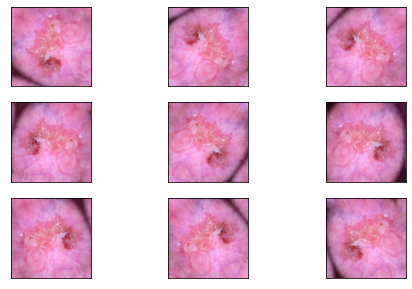

In [ ]:
# To visualize how the augmentation strategy worked for one instance of training image.
fig=plt.figure(figsize=(8,5))
#To display the first image from all the 9 categories along with the names of the categories
for imgs,_ in train_ds.take(1):

    for i in range(len(class_names)):
        aug_images=data_aug(imgs)
        ax=fig.add_subplot(3,3,1+i,xticks=[],yticks=[])
        #img_path=(img for img in im_array if class_names[i] in img)
        #ax.set_title(class_names[i])
        plt.imshow(aug_images[0].numpy().astype("uint8"))
    plt.show()


### Creating the model, compiling and training:


In [ ]:
# Dropout layer is also used as there is an evidence of overfitting in the above findings

# model

input_data=keras.Input(shape=(img_height,img_width,3))
t=data_aug(input_data)
t=layers.Rescaling(1./255)(t)
# a keras convolutional layer is called Conv2D
# note that the first layer needs to be told the input shape explicitly
# first conv layer
#model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
model = Sequential()
t=Conv2D(16,3,padding="same",
                 activation='relu',
                 input_shape=(img_height,img_width,-1))(t)
t=MaxPooling2D()(t)
# second conv layer
t=Conv2D(32,3,padding="same",
                 activation='relu',
                 input_shape=(img_height,img_width,-1))(t)
model.add(MaxPooling2D())
# third conv layer
t=Conv2D(64, 3,activation='relu')(t)
t=MaxPooling2D()(t)

# flatten and put a fully connected layer
t=Flatten()(t)
t=Dense(128,activation='relu')(t)


# softmax layer
t=Dropout(0.5)(t)

output_data=Dense(num_classes)(t)
model=keras.Model(input_data,output_data)
# model summary
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                             

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(train_ds,
validation_data=val_ds,
batch_size=batch_size,
epochs=epochs)

Epoch 1/20
56/56 [==============================] - 89s 2s/step - loss: 2.5449 - accuracy: 0.2182 - val_loss: 1.9205 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 89s 2s/step - loss: 1.9151 - accuracy: 0.2812 - val_loss: 1.8882 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 87s 2s/step - loss: 1.8144 - accuracy: 0.3359 - val_loss: 1.6507 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 89s 2s/step - loss: 1.8234 - accuracy: 0.3387 - val_loss: 1.6841 - val_accuracy: 0.4497
Epoch 5/20
56/56 [==============================] - 88s 2s/step - loss: 1.7126 - accuracy: 0.4046 - val_loss: 1.5845 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 87s 2s/step - loss: 1.6057 - accuracy: 0.4252 - val_loss: 1.5032 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 87s 2s/step - loss: 1.6604 - accuracy: 0.4051 - val_loss: 1.5870 - val_accuracy: 0.4586
Epoch 8/20
56/56 [==

### Visualizing the results

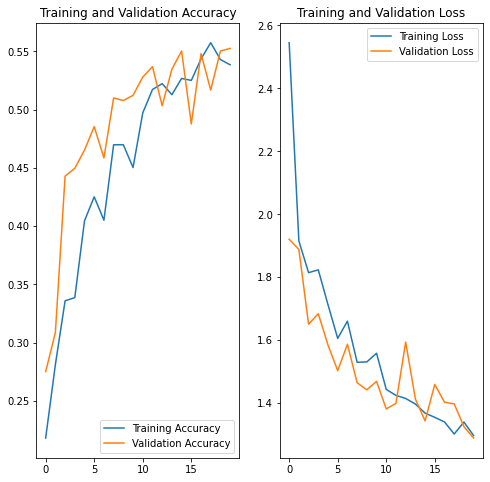

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit: 
<font color="red" >There is no evidence of model overfit or underfit.

So, the model has improved as compared to the previous model run. </font>

####The distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
!pip install Augmentor



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
import Augmentor
path_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
for c in class_names:
    p=Augmentor.Pipeline(path_train+c)
    p.rotate(probability=0.8,max_left_rotation=20,max_right_rotation=20)
    p.sample(1200)
'''

'\nimport Augmentor\npath_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"\nfor c in class_names:\n    p=Augmentor.Pipeline(path_train+c)\n    p.rotate(probability=0.8,max_left_rotation=20,max_right_rotation=20)\n    p.sample(1200)\n'

#### Findings: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Findings after the model fit:
There is no evidence of model overfit or underfit.

So, the model has improved as compared to the previous model run.

